<h1> Análisis de espectros </h1>

<h2> Líneas de emisión </h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib ipympl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 12,
})

In [2]:
def clean_nist_value(value):
    """Función para limpiar valores del formato NIST"""
    if pd.isna(value) or value == '""' or value == '=""' or value == '=""""':
        return np.nan
    if isinstance(value, str):
        cleaned = value.replace('=', '').replace('"', '').strip()
        if cleaned == '':
            return np.nan
        # Intentar convertir a número si es posible
        try:
            return float(cleaned) if '.' in cleaned or 'e' in cleaned.lower() else int(cleaned)
        except ValueError:
            return cleaned
    return value

In [3]:
df_lines = pd.read_csv('lines.csv', dtype=str) # Cargamos el archivo como texto para limpiarlo

df_lines = df_lines.map(clean_nist_value) # Limpiamos los valores

# Columnas numéricas
numeric_cols = ['obs_wl_air(nm)', 'ritz_wl_air(nm)', 'intens', 'Aki(s^-1)', 'Ei(eV)', 'Ek(eV)']
for col in numeric_cols:
    df_lines[col] = pd.to_numeric(df_lines[col], errors='coerce')

In [4]:
# Seleccionamos líneas específicas para el análisis
# Nuevo DataFrame para almacenar los datos del elemento, sp_num ritz_wl e intens
df = df_lines[df_lines['intens'] > 150].dropna(subset=['ritz_wl_air(nm)', 'intens'])[['element', 'sp_num', 'ritz_wl_air(nm)', 'intens']].copy()

Hay valores con una intensidad igual, por lo que nos quedamos con el primero de estos.

In [5]:
df = df.drop_duplicates(subset=['intens'], keep='first') # Eliminamos duplicados basados en la intensidad

df.head(10)

df.to_csv('lineas_new.csv')

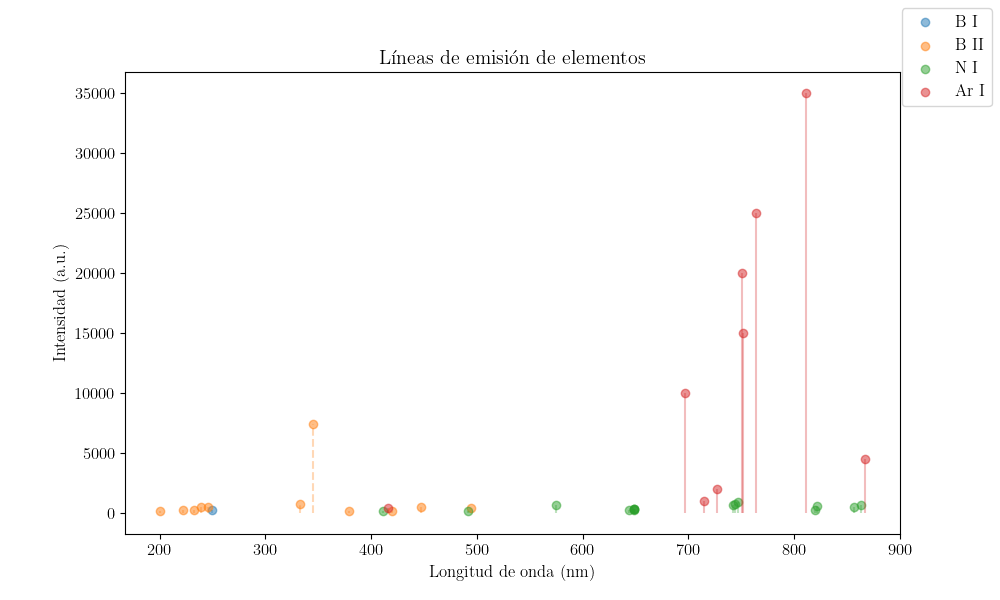

In [6]:
plt.close() # Cerrar la figura anterior

fig, axs = plt.subplots(figsize=(10, 6))

wavelength = df['ritz_wl_air(nm)']
intensidad = df['intens']

# Crear una columna para el elemento y el número
df['element_sp'] = df['element'] + ' ' + np.where(df['sp_num'] == 1, 'I', 'II')


conditions = [
    df['element_sp'] == 'B I',
    df['element_sp'] == 'B II',
    df['element_sp'] == 'N I',
    df['element_sp'] == 'Ar I',
]

axs.set_title("Líneas de emisión de elementos")
axs.set_xlabel("Longitud de onda (nm)")
axs.set_ylabel("Intensidad (a.u.)")

for condition in conditions:
    scatter = axs.scatter(df[condition]['ritz_wl_air(nm)'], df[condition]['intens'], label=df[condition]['element_sp'].iloc[0], alpha=0.5) 

    color = scatter.get_facecolors()[0]
    sp_num = df[condition]['sp_num'].iloc[0]
    linestyle = '--' if sp_num == 2 else '-'

    # Líneas verticales
    for wl, intens in zip(df[condition]['ritz_wl_air(nm)'], df[condition]['intens']):
        if sp_num == 2: # Ionizado
            axs.vlines(wl, 0, intens, alpha=0.3, color=color, linestyle=linestyle)
        else: # Excitado
            axs.vlines(wl, 0, intens, alpha=0.3, color=color, linestyle=linestyle)



fig.legend()
plt.show()